# Annotated visualisations of longevity abstracts for AIIM publication - keyphrases

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# config
N_GRAM_LEN = 3

## Load data

In [3]:
import pandas as pd

df = pd.read_pickle('pubmed-covid-19.pkl')
len_before = len(df)

df = df[df["abstract"].str.len() >= 100]
f"Dokument kept: {len(df)}/{len_before}"

'Dokument kept: 10000/10000'

## Preprocess and compute embeddings

In [4]:
import string
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from lemmagen.lemmatizer import Lemmatizer
from lemmagen import DICTIONARY_ENGLISH
from textsemantics import specific_words


nltk.download('stopwords', quiet=True)
lemmatizer = Lemmatizer(dictionary=DICTIONARY_ENGLISH)
stop_words = set(stopwords.words('english'))

def preprocess(corpus):
    tokenizer = RegexpTokenizer("\w+")
    preprocessed = list()
    for text in corpus:
        text = text.translate(text.maketrans('', '', string.punctuation))
        tokens = tokenizer.tokenize(text.lower())
        tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stop_words 
                  and len(token) > 2 and not token.isnumeric()]

        tokens = list(filter(lambda a: a != '', tokens))  
        preprocessed.append(tokens)
    return preprocessed

abstracts = list(df['abstract'])
tokens_list = preprocess(abstracts)
doc_embs, word_embs, _, _ = specific_words.prepare_embeddings(tokens_list, 'en')

## Compute t-SNE embedding

In [5]:
%%time
from openTSNE import TSNE

tsne = TSNE(
    perplexity=500,
    initialization="pca",
    metric="cosine",
    n_jobs=2,
    random_state=0,
)

embedding_ = tsne.fit(doc_embs)

CPU times: user 4min 29s, sys: 4.28 s, total: 4min 33s
Wall time: 2min 27s


## Fucntion for clustering and visualisation

In [6]:
from orangecontrib.text.stats import hypergeom_p_values
from sklearn.feature_extraction.text import CountVectorizer
from Orange.statistics.util import FDR
import matplotlib.patheffects as path_effects
from sklearn.mixture import GaussianMixture
from matplotlib import pyplot as plt
import numpy as np
from collections import Counter


CB_color_cycle = [
    '#377eb8', '#ff7f00', '#4daf4a',
    '#f781bf', '#a65628', '#984ea3',
     '#999999', '#e41a1c', '#dede00'
]


def take_first_n(kws, n):
    """ 
    Take first n without duplications which are present because of normaliztion
    in YAKE    
    """
    selected = []
    for kw in kws:
        if len(selected) >= n:
            break
        if kw not in selected:
            selected.append(kw)
    assert len(selected) <= n
    return selected
    

def hypergeom_clusters(points, labels, keywords, ax):
    num_kw = 20
    clusters = []
    lengths = []
    cl_labels = list(set(labels) - {-1})
    
    # gather keywords in list
    for i, cluster in enumerate(cl_labels):
        cluster_idx = np.where(labels == cluster)[0]
        clis = set(cluster_idx)
        all_kws = [
            take_first_n(kws, num_kw) for i, kws in enumerate(keywords) if i in clis
        ]
        lengths.append(len(all_kws))
        clusters += all_kws
    
    # count appearances
    def dummy(doc):
        return doc
    cv = CountVectorizer(tokenizer=dummy, preprocessor=dummy)
    x = cv.fit_transform(clusters)
    features = np.array(cv.get_feature_names_out())
    
    start = 0
    for i, ll in enumerate(lengths):
        # find words that should be specific for a group with hypergeom test
        selected = x[start:start+ll]
        p_values = hypergeom_p_values(x, selected)
        fdr = FDR(p_values)
        assert len(features) == len(fdr)
        bellow_threshold = set(features[np.array(fdr) < 0.05].tolist())
        
        # use counts as measure but select only words which p-vales pass the threshold
        c = Counter([k for kws in clusters[start:start+ll] for k in kws])
        selected = []
        for el, _ in c.most_common():
            if len(selected) >= 5:
                break
            if el in bellow_threshold:
                selected.append(el)     
        
        start += ll 
        # plot
        cluster_idx = np.where(labels == cl_labels[i])[0]
        centroid = np.mean(points[cluster_idx, :], axis=0)
        ann = "\n".join(selected) + f'\n\n{i+1}'
        ax.text(centroid[0], centroid[1], ann,                 
                fontdict={'fontweight': 'bold', 'fontsize': 'xx-large'},
                va='center', ha='center')

        
def create_plot(kw, title='', label_method=hypergeom_clusters, sublinear_tf=False):

    estimator = GaussianMixture(n_components=8,
                covariance_type='full', max_iter=20, random_state=0)

    estimator.fit(embedding_)
    _, ax = plt.subplots(figsize=(12, 12))
    plt.style.use('seaborn')

    probs = estimator.predict_proba(embedding_)
    labels = np.argmax(probs, axis=1)
    max_probs = np.max(probs, axis=1)
    labels[max_probs < 0.6] = -1

    n_noise = list(labels).count(-1)
    #palette = sns.color_palette('colorblind', 8)
    palette = CB_color_cycle
    cs = [palette[l] if l > -1 else (0.5, 0.5, 0.5) for l in labels]
    s = [36 if l > -1 else 9 for l in labels]
    plt.scatter(embedding_[:, 0], embedding_[:, 1], c=cs,
                alpha=0.3, s=s);

    desc = label_method(embedding_, labels, kw, ax)

    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_facecolor("white")
#     plt.title(title)

    return desc, labels

## Visualisation with TF-IDF keywords

In [7]:
%%time 
from sklearn.feature_extraction.text import TfidfVectorizer


def tfidf_keywords(tokens):
    joined_texts = [" ".join(tokens) for tokens in tokens]
    vectorizer = TfidfVectorizer(ngram_range=(1, N_GRAM_LEN))
    X = vectorizer.fit_transform(joined_texts)
    words = vectorizer.get_feature_names_out()

    keywords = []
    for row in X:
        features = [(words[i], row[0, i]) for i in row.nonzero()[1]]
        keywords.append(sorted(features, key=lambda tup: tup[1], reverse=True))
    return keywords


tfidf_kw = tfidf_keywords(tokens_list)
tfidf_kw = [[x for x, _ in wds] for wds in tfidf_kw]

CPU times: user 1min 41s, sys: 745 ms, total: 1min 41s
Wall time: 1min 41s


/home/primoz/miniconda3/envs/text-semantics/lib/python3.8/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


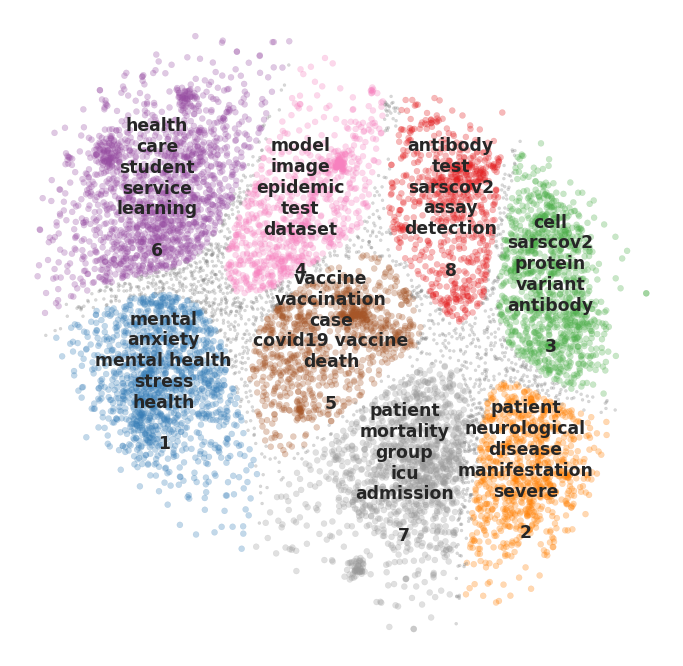

In [15]:
tfidf_desc = create_plot(tfidf_kw,  title='tf-idf - hyper phrases', label_method=hypergeom_clusters)
plt.savefig("annotations-covid-tf-idf.pdf", bbox_inches='tight')

## Visulaisation with YAKE keyowrds

In [9]:
%%time 
import yake

custom_kw_extractor = yake.KeywordExtractor(lan="en", n=3, top=20)
def yake_method(text):
    kw = custom_kw_extractor.extract_keywords(text)
    return [" ".join(lemmatizer.lemmatize(w) for w in x.split()) for x, _ in kw]

yake_keywords = [yake_method(txt) for txt in df["abstract"]]

CPU times: user 17min 36s, sys: 4.66 s, total: 17min 41s
Wall time: 17min 34s


/home/primoz/miniconda3/envs/text-semantics/lib/python3.8/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


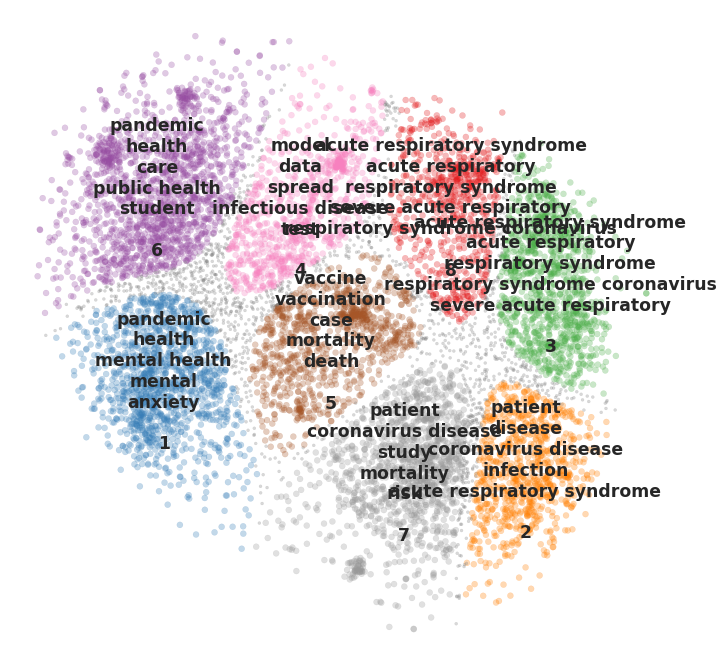

In [10]:
yake_desc = create_plot(yake_keywords, title='YAKE!-hyper phrases', label_method=hypergeom_clusters)
# plt.savefig('document-map-yake-hyper.jpg', dpi=300)
plt.savefig("annotations-covid-yake.pdf", bbox_inches='tight')

## Visulaisation with Transformers keyowrds

In [9]:
%%time

from bert_keyword_extractor import TransformerKeywordExtractor
from string import punctuation

def lemmatize_ph(phrase):
    return " ".join(lemmatizer.lemmatize(w) for w in phrase.split())

def get_kws(model_path):
    extractor = TransformerKeywordExtractor(model_path)
    bert_keywords = extractor.extract_keywords(df['abstract'])
    del extractor
    return [[lemmatize_ph(w) for w, _ in kws] for kws in bert_keywords]
        
crosloengual_keywords = get_kws('models/crosloeng')

loading configuration file models/crosloeng/config.json
Model config BertConfig {
  "_name_or_path": "EMBEDDIA/crosloengual-bert",
  "architectures": [
    "BertForTokenClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "finetuning_task": "ner",
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "B",
    "1": "I",
    "2": "O"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "B": 0,
    "I": 1,
    "O": 2
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "torch_dtype": "float32",
  "transformers_version": "4.9.0.dev0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 49601
}

Didn't find file models/crosloeng/added_tokens.json. We won't load it.
loading file models/crosloeng/vocab.txt
load

  0%|          | 0/12 [00:00<?, ?ba/s]

The following columns in the test set  don't have a corresponding argument in `BertForTokenClassification.forward` and have been ignored: tokens.
***** Running Prediction *****
  Num examples = 11726
  Batch size = 8


CPU times: user 3min 14s, sys: 3min 15s, total: 6min 29s
Wall time: 6min 2s


/home/primoz/miniconda3/envs/text-semantics/lib/python3.8/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


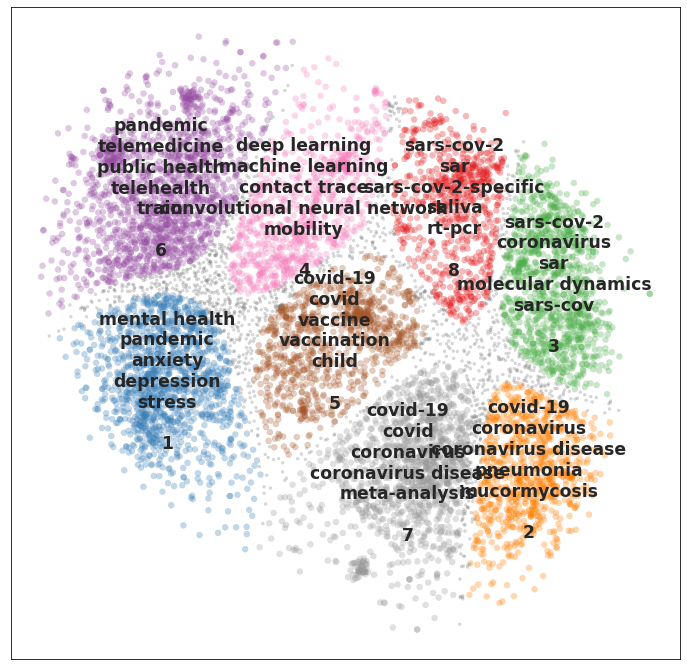

In [10]:
bert_desc = create_plot(crosloengual_keywords, title='BERT-hyper phrases', label_method=hypergeom_clusters)
plt.savefig("annotations-covid-croslo.pdf", bbox_inches='tight')

## TextRank

In [16]:
%%time
import spacy
import pytextrank

def text_rank(texts):
    nlp = spacy.load("en_core_web_sm")
    nlp.add_pipe("textrank")
    
    def text_rank(text):
        doc = nlp(text)
        return [" ".join(lemmatizer.lemmatize(w) for w in x.text.split()) 
                for x in doc._.phrases if len(x.text.split()) <= N_GRAM_LEN]

    return [text_rank(t) for t in texts]

text_rank_keywords = text_rank(df["abstract"])

CPU times: user 9min 50s, sys: 0 ns, total: 9min 50s
Wall time: 9min 49s


/home/primoz/miniconda3/envs/text-semantics/lib/python3.8/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


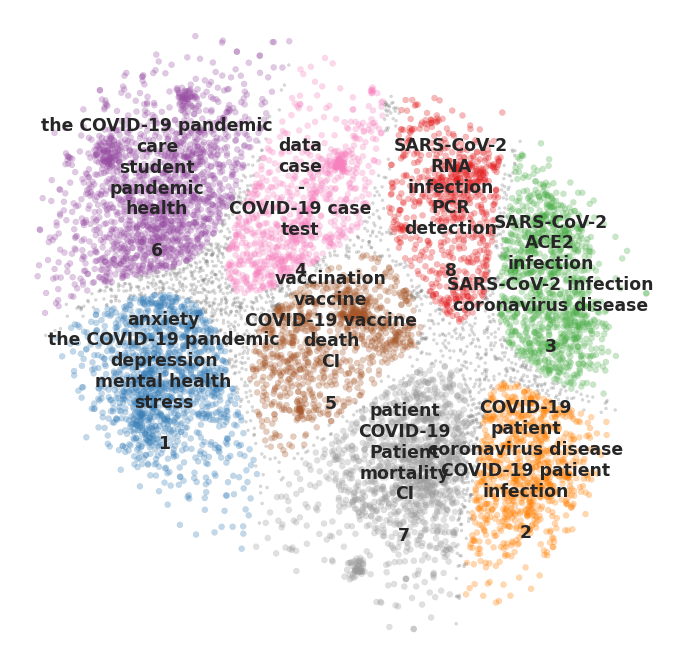

In [17]:
bert_desc = create_plot(text_rank_keywords, title='TextRank-hyper phrases', label_method=hypergeom_clusters)
plt.savefig("annotations-covid-textrank.pdf", bbox_inches='tight')

## Central titles for clusters

In [18]:
from sklearn.metrics import silhouette_samples
clusters = bert_desc[1]
s = silhouette_samples(embedding_, clusters)
n = 5

for c in set(clusters) - {-1}:
    sil = s[clusters == c]
    titles = df["title"][clusters == c]
    idx_ = np.argpartition(sil, -n)[-n:]
    
    print("%Cluster ", c+1)
    print("%---------")
    print("\n".join(f"%{x}" for x in titles.iloc[idx_]))

%Cluster  1
%---------
%Experiences of Work-Family Conflict and Mental Health Symptoms by Gender Among Physician Parents During the COVID-19 Pandemic.
%Who Is Suffering from the "Corona Blues"? An Analysis of the Impacts of the COVID-19 Pandemic on Depression and Its Implications for Health Policy.
%Fear of COVID-19 lead to procrastination among Turkish university students: The mediating role of intolerance of uncertainty.
%Sleep Quality and Mental Health of Medical Students in Greece During the COVID-19 Pandemic.
%Prevalence of Psychological Distress in Hawai'i during the COVID-19 Pandemic: Exploring Disparities Using 11 Waves of Data from the Household Pulse Survey.
%Cluster  2
%---------
%Multisystem inflammatory syndrome in adults after acute coronavirus disease 2019 in a Japanese woman: A case report.
%Systemic inflammatory syndrome in children during COVID-19 pandemic in Ceará state, northeastern Brazil: an observational study.
%Autoimmune Encephalitis After SARS-CoV-2 Infection: